# Datasets & Assets (`.datasets`)

Estimated reading time: 8'

## What you'll learn

This guide's objective is to help you get familiar with datasets and assets than can be hosted on a Datasite server.

## Introduction

Datasets in PySyft are the key to how PySyft allow researchers to conduct studies in a **remote manner**, on private data that cannot be accessed directly. There are two types of data to be hosted on a PySyft server:
- **private data**: the original data that cannot be released due to its sensitive nature and associated risks
- **mock data**: a fake version of the data that mimics the original one, by preserving, at minimum, the dataset schema and value distributions. This is either generated entirely from scratch or it's a syntethic version with appropriate privacy guarantees.

Both of the these datasets are part of an object, called `Asset`, which has a dual behaviour - it is a pointer to the private data, but depending on the permissions, an user can access the private or the mock data. Moreover, such assets are conveniently grouped, if related, under a `Dataset` object, allowing to describe the assets more broadly.

### Structuring Datasets and Assets

A **Syft Dataset** can contain one or more **Syft Assets**.

```{admonition} Warning
An asset must belong to a dataset and cannot be uploaded on its own. 
```

Below are a few examples of how one can organise their assets within a dataset:

**Example 1: Training and Testing Data**\
The dataset is composed of two assets, one with testing data, and another asset with training data. These two can be uploaded together into the same dataset.

**Example 2: Chronological Data**\
The dataset is composed of multiple assets collected during different time periods, for example *data-july-14.csv*, *data-july-17.csv*, and *data-august-12.csv*. All these three assets can be uploaded into the same dataset.

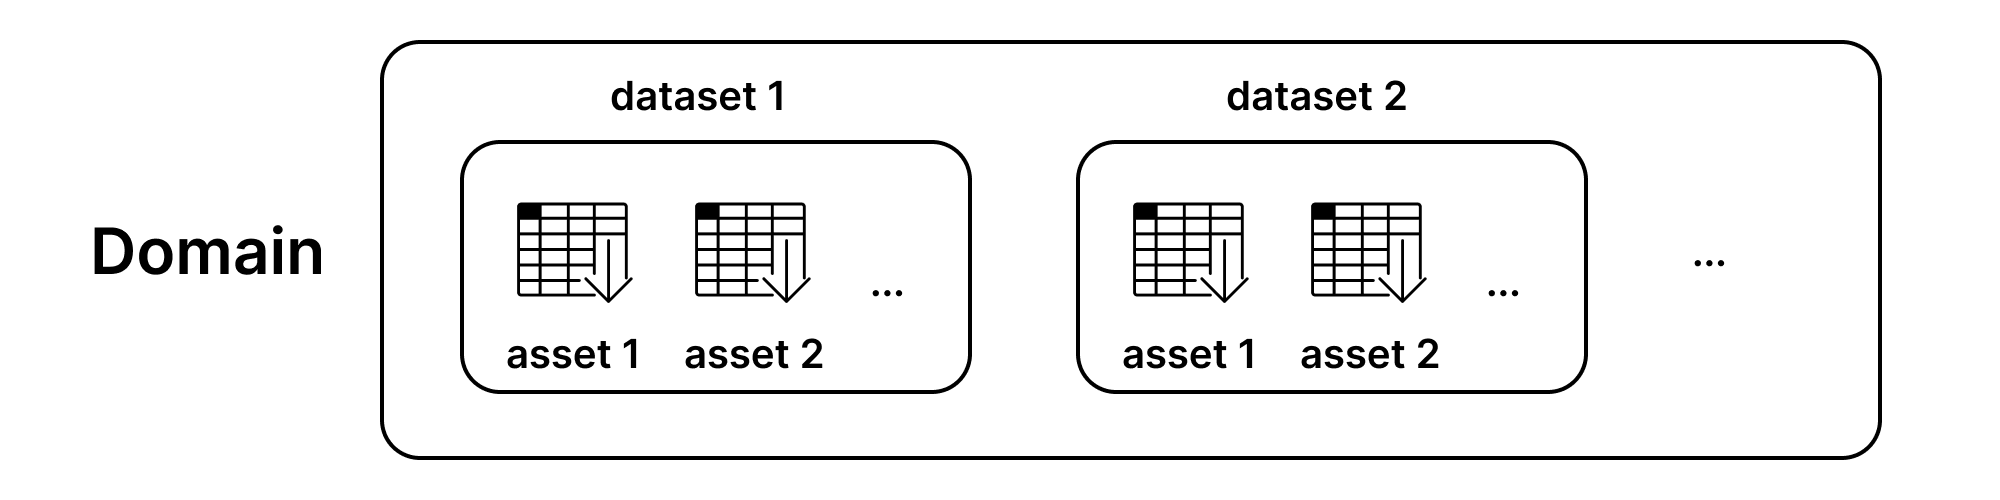

### Differences for a low-side & high-side configuration

Specific deployments are particularly defined by the data arrangement across servers: a low-side server can host only mock data, while high-side servers benefit from extra security and can contain private data.

Configuring the server in this manner does not require a custom configuration. The only aspect you need to take pay attention to is never uploading an `Asset` with private data on a low-side.

```{warning} Remember!
- Private (or sensitive) data must only be uploaded on the high-side server.
- The low-side server must only contain mock data.
```

For the high-side servers, it is entirely up to the data owner if they would like to have the mock data available for testing purposes. 

### Fetch test data

To show how datasets and assets can be created and further uploaded, we will launch now a test server and start by downloading a Kaggle dataset for illustration ([Age Dataset 2023](https://www.kaggle.com/datasets/lasaljaywardena/age-dataset-2023)).

In [ ]:
import syft as sy

server = sy.orchestra.launch(name="test_server", port="auto", dev_mode=False, reset=True)

# logging in with default credentials
do_client = sy.login(email="info@openmined.org", password="changethis", port=server.port)

In [ ]:
!curl -O https://openminedblob.blob.core.windows.net/csvs/ages_dataset.csv
!curl -O https://openminedblob.blob.core.windows.net/csvs/ages_mock_dataset.csv

In [ ]:
import pandas as pd
import syft as sy

age_df = pd.read_csv("ages_dataset.csv")
age_df = age_df.dropna(how="any")
age_df.head()

age_mock_df = pd.read_csv("ages_mock_dataset.csv")
age_mock_df = age_mock_df.dropna(how="any")
age_mock_df.head()


## Create an Asset

To create an asset (`syft.Asset`), the mandatory arguments are:
- `name (type: string)`: name of the asset, acts as a key among the assets in the same dataset and it must be unique
- `data`: contains the private data; if you are preparing the assets for the low-side domain, this can also be replaced wit the mock data.
- `mock`: contains the fake data; this data should have the same schema as the private data, but does not contain any sensitive information

Additional arguments are available:
- `description (type: string)`: a short description of the asset. It can only be a string, does not suppport Markdown or HTML.
- `countributors (type: list)`: a list of `syft.Contributors` listing the authors of the asset data and specifying a contact email for further questions
- `mock_is_real (type: bool)`: states whether the mock data is syntethically generated from the original data. If fake, this should be false.
- `mock.shape (type: tuple)`: the shape of the data if the data is either a Pandas DataFrame or a Numpy Array.
- `data_subjects`: deprecated - do not use.

```{note} Note for high-side servers
If you are uploading data to the high-side and there is no mock available or it is not considered necessary, you can pass `mock=sy.ActionObject.empty()` to signal this.
```

In [ ]:
main_contributor = sy.Contributor(name="Jeffrey Salazar", role="Dataset Creator", email="jsala@ailab.com")

asset = sy.Asset(
    name="asset_name",
    description="this is my asset",
    data=age_df, # real dataframe
    mock=age_mock_df, # mock dataframe
    contributors=[main_contributor]
)

## Allowed data types in Asset

In this setup, the data is directly uploaded to the server. The only data formats supported are:
- Python primitive types (int, string, list, dict, ..)
- Pandas Dataframe
- Numpy Arrays

If you want to upload custom data formats, we recommmend using the blob storage functionality. This is currently in beta and documentation will be added soon.

## Create a Dataset

To create a dataset, the available arguments are:
- `name (type: string)`: name of the dataset, acts as a key among datasets and it must be unique
- `asset_list (type: [syft.Assets])`: a list of assets which contain the actual data uploaded as part of the dataset
- `description (type: string)`: brief additional information about the data found in the dataset; it supports markdown.

Additional optional arguments are available:
- `citation (type: string)`: indications on how to cite the dataset if used
- `url (type: string)`: link related to the dataset
- `contributors_list (type: [Contributor])`: contributors to the dataset

In [ ]:
dataset = sy.Dataset(
    name="Dataset name",
    description="**Dataset description**",
    asset_list=[asset],
    contributors=[main_contributor]
)

```{warning} Preserve naming on low & high
For a low-side & high-side deployment, it is very important for the datasets and assets to carry the same name. This ensures that code written on the low-side and using low-side assets can be easily executed on the high side. 
```

### Data Upload

To upload a dataset on a domain, use the `upload_dataset` function. You need to be logged in into the domain (low side or high side).

```{note} Info
Assets can be only uploading as part of a dataset.
```

In [ ]:
# Uploading the dataset
do_client.upload_dataset(dataset)

## Access Datasets

PySyft implements access control via the roles assigned to the user. Briefly:
- Admins, data owners, can access, update and delete the datasets in full
- Data Scientists/Guests can only access the mock counterpart of all datasets hosted on the server they are registered on. Be careful to not pass private data via the mock argument.

In [ ]:
# Access is possible via the datasets API
do_client.datasets

In [ ]:
# Retrieve one dataset
dataset_retrieved = do_client.datasets[0]
dataset_retrieved

In [ ]:
# Retrieve an asset
asset_retrieved = dataset_retrieved.assets[0]
asset_retrieved

In [ ]:
# Accessing the mock or private part of an asset directly:
mock_data = dataset_retrieved.assets[0].mock

private_data = dataset_retrieved.assets[0].data

mock_data

Note that only an admin/data owner can access `dataset_retrieved.assets[0].data`.

## Update Datasets

Updating of the data is not possible for uploaded objects. Instead, you can only update an asset, dataset before it is being uploaded.

To change a dataset that was uploaded, we recommend you delete and re-create the object.

In [ ]:
asset.set_description("Updated asset description")
dataset.add_asset(asset, force_replace=True)

In [ ]:
do_client.datasets

## Delete Datasets


It is recommended to proceed carefully with deletion, in case it is being used by different code requests of users. 

In [ ]:
do_client.api.dataset.delete(uid = do_client.datasets[0].id)
do_client.datasets

## Dataset Description

Descriptions are important attributes for datasets, as they are the key for helping the data scientist understand the data, despite not having access to it. Thus, a well-wrritten comprehensive description can help answer questions and clarify assumptions that the data scientist might have about the data.

### Markdown support
PySyft allows for the dataset description to be written in Markdown, to enable data owners to properly capture all the information needed about the data. As such, you can write the description directly in a markdown editor ([Editor.md](https://pandao.github.io/editor.md/en.html), [Markdown Live Preview](https://markdownlivepreview.com/)), edit and preview it until it's good to go, and in the end just copying the final markdown in the description field when creating a dataset.

The description can capture dimensions such as:
- **Summary of the dataset**: short description mentioning what type of data (numerical, text, image, mixed) and the source domain; 
- **Dataset usage policy**: describe the data usage policies the researchers must adhere to in their study to have their requests approved
- **Use cases**: what use cases this dataset has been proposed for
- **Data collection and pre-processing**: information on how the features were collected and/or derived, and how accurate the data is
- **Key features**: a data dictionary, explaining all the columns presented in the dataset. We recommend mentioning if there is are relationships between the columns
- **Code snippets**: these can be included for common operations, for example snippet on how to load the dataset to get started with it
- **Citations**: how to cite the dataset


Let's see an example

In [ ]:
description_template = '''### About the dataset
This extensive dataset provides a rich collection of demographic and life events records for individuals across multiple countries. It covers a wide range of indicators and attributes related to personal information, birth and death events, gender, occupation, and associated countries. The dataset offers valuable insights into population dynamics and various aspects of human life, enabling comprehensive analyses and cross-country comparisons. The dataset is the largest one on notable deceased people and includes individ- uals from a variety of social groups, including but not limited to 107k females, 90k researchers, and 124 non-binary indi- viduals, spread across more than 300 contemporary or histor- ical regions.

### Dataset usage policy
This dataset is subject to compliance with internal data use and mis-use policies at our organisation. The following rules apply:
- only aggregate statistics can be released from data computation
- data subjects should never be identifiable through the data computation outcomes
- a fixed privacy budget of eps=5 must be preserved by each researcher

### Data collection and pre-processing
The dataset is based on open data hosted by Wikimedia Foundation.

**Age**
Whenever possible, age was calculated based on the birth and death year mentioned in the description of the individual.

**Gender**
Gender was available in the original dataset for 50% of participants. For the remaining, it was added from predictions based on name, country and century in which they lived. (97.51% accuracy and 98.89% F1-score)

**Occupation**
The occupation was available in the original dataset for 66% of the individuals. For the remaining, it was added from predictions from a multiclass text classificator model. (93.4% accuracy for 84% of the dataset)

More details about the features can be found by reading the paper.

### Key features
1. **Id**: Unique identifier for each individual.
2. **Name**: Name of the person.
3. **Short description**: Brief description or summary of the individual.
4. **Gender**: Gender/s of the individual.
5. **Country**: Countries/Kingdoms of residence and/or origin.
6. **Occupation**: Occupation or profession of the individual.
7. **Birth year**: Year of birth for the individual.
8. **Death year**: Year of death for the individual.
9. **Manner of death**: Details about the circumstances or manner of death.
10. **Age of death**: Age at the time of death for the individual.
11. **Associated Countries**: Modern Day Countries associated with the individual.
12. **Associated Country Coordinates (Lat/Lon)**: Modern Day Latitude and longitude coordinates of the associated countries.
13. **Associated Country Life Expectancy**: Life expectancy of the associated countries.

### Use cases
- Analyze demographic trends and birth rates in different countries.
- Investigate factors affecting life expectancy and mortality rates.
- Study the relationship between gender and occupation across regions.
- Explore correlations between age of death and associated country attributes.
- Examine patterns of migration and associated countries' life expectancy.


### Getting started

```
!curl -O https://openminedblob.blob.core.windows.net/csvs/ages_dataset.csv

age_df = pd.read_csv("ages_dataset.csv")
```

### Execution environment
The data is hosted in a remote compute environment with the following specifications:
- X CPU cores
- 1 GPU of type Y
- Z RAM
- A additional available storage

### Citation
Annamoradnejad, Issa; Annamoradnejad, Rahimberdi (2022), “Age dataset: A structured general-purpose dataset on life, work, and death of 1.22 million distinguished people”, In Workshop Proceedings of the 16th International AAAI Conference on Web and Social Media (ICWSM), doi: 10.36190/2022.82
'''

In [ ]:
# Create a dataset with description

dataset = sy.Dataset(
    name="Dataset name with description",
    description=description_template,
    asset_list=[
        sy.Asset(
            name="Age Data 2023",
            data=age_df,
            mock=age_mock_df
    )],
    contributors=[main_contributor]
)

do_client.upload_dataset(dataset)

In [ ]:
do_client.datasets[0]